# Gensim Movie Tutorial

Python の Gensim ライブラリを使ったチュートリアル https://github.com/RaRe-Technologies/movie-plots-by-genre の練習ノートです。

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from smart_open import smart_open
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import random
import gensim.downloader as api
from gensim.matutils import unitvec
from nltk.corpus import stopwords
from pprint import pprint

このチュートリアルの目的は、映画の粗筋からジャンル名を当てる事です。まず素材となるデータを読み込みます。

In [3]:
tagged_plots_movielens = "https://raw.githubusercontent.com/RaRe-Technologies/movie-plots-by-genre/master/data/tagged_plots_movielens.csv"
df = pd.read_csv(smart_open(tagged_plots_movielens)).dropna()
display(df)
print(f'plot: {df.iloc[12]["plot"]}')
print(f'tag: {df.iloc[12]["tag"]}')

,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy
3,3,6,Hunters and their prey--Neil and his professio...,action
4,4,7,An ugly duckling having undergone a remarkable...,romance
...,...,...,...,...
2443,2443,148618,Three kids who travel back in time to 65 milli...,animation
2444,2444,148624,"Top Cat and the gang face a new police chief, ...",animation
2445,2445,149088,Raggedy Ann and the rest of the toys in Marcel...,animation
2446,2446,149406,"Continuing his ""legendary adventures of awesom...",comedy


plot: In a future world devastated by disease, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human population on the planet.
tag: sci-fi


12 行目の内容を抜き出して見ました。plot が粗筋、tag がジャンル名です。これから plot を読んで tag を当てるものを作ります。tag の分布を見てみます。

Comedy / All: 0.32138442521631644


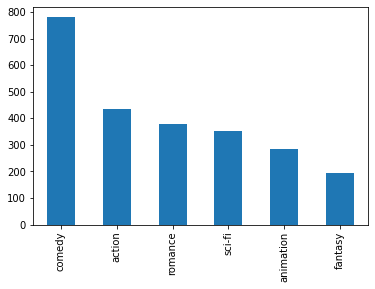

In [4]:
df.tag.value_counts().plot.bar()
print("Comedy / All:", len(df[df.tag=="comedy"]) / len(df))

comedy の tag が突出して多いので、何でもかんでも comedy と予測しただけで 32% の正確性になってしまいます。

sklearn の train_test_split 関数を使って元のデータの9割を教師データとして取り分け、残りの1割をテストデータに取っておきます。ジャンルが偏ってないか一応確認。

Count train: 2184
Count test_data: 243


<AxesSubplot:>

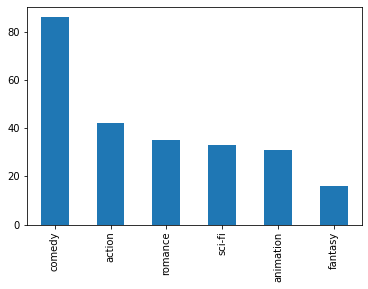

In [5]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
print("Count train:", len(train_data))
print("Count test_data:", len(test_data))
test_data.tag.value_counts().plot.bar()


## Model evaluation approach

これから色々な手法を比較評価していくための枠組みを作ります。

In [6]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    target_names = df.tag.unique()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

ここでは、predict という関数を作って予測器を評価します。predict に3つの引数を与えます。それぞれ

* vectorizer: 文章をベクトルに変換する。
* classifier: ベクトルを使って tag を予測する。
* data: 上で取り分けておいた test_data。

となります。では確認のため最もデタラメな予測器を与えてみましょう。

accuracy 0.35390946502057613
confusion matrix
 [[ 0  0 42  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0 86  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  0 35  0  0  0]
 [ 0  0 33  0  0  0]]
(row=expected, col=predicted)


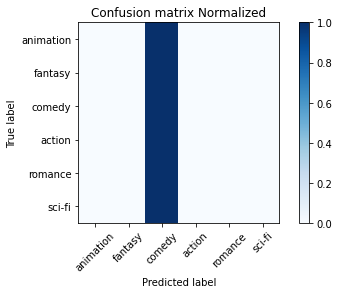

In [7]:
# どんな文章にも [0] を返すベクトル変換器
class Bogus_vectorizer:
    def transform(self, texts):
        return np.zeros((len(texts), 1), int)

# どんな入力にも "comedy" をデタラメに返す予測器
class Bogus_classifier:
    def fit(self, features, tags):
        self.tags = tags.values
    def predict(self, features):
        return np.full(len(features), "comedy")
        #return np.array([random.choice(self.tags) for _ in features]) # こっちの行を有効にするとランダムに返します。

bogus_vectorizer = Bogus_vectorizer()
bogus_vectorizer.transform(test_data["plot"])

bogus_classifier = Bogus_classifier()
bogus_classifier.fit(bogus_vectorizer.transform(train_data["plot"]), train_data["tag"])
bogus_classifier.predict(bogus_vectorizer.transform(test_data["plot"]))

predict(bogus_vectorizer, bogus_classifier, test_data)

Confusion matrix の横軸が予測されたジャンル、縦軸が本当のジャンルです。結果の通り、本当ジャンルに関わらずこのデタラメ予測器は "comedy" と判定しますがそれでも accuracy は 35% 出ます。という事は少なくとも 35% 以上の精度が出ないと頑張った甲斐がないという事になります。

## Bag of words

まず一番簡単な Bag of words と LogisticRegression を試します。Bag of worlds とは、単語の出現頻度を数えて文の特徴ベクトルとする物です。例えば "bye bye now" なら bye: 2, now: 1 のようなベクトルになります。出来た特徴ベクトルが出来ると、教師データで LogisticRegression を訓練して予測器を作ります。

ここでは sklearn の CountVectorizer を使います。文章を単語ごとに区切る tokenizer を内蔵している優れものです。数える単語の数を上位頻出 3000 語に限ります。

In [8]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word",
    stop_words='english',
    max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['plot'])
train_data_features

CPU times: user 107 ms, sys: 2.3 ms, total: 109 ms
Wall time: 108 ms


<2184x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 49189 stored elements in Compressed Sparse Row format>

train_data_features は粗筋の数 x 単語の数 (最大 3000) の表で、単語が何件出現するかを記録したものです。

試しに教師データの粗筋がどのように変換されたか見てみます。CountVectorizer はレアすぎる単語や頻繁すぎる単語は除外してくれるので、それなりに文章の特徴を表す単語がカウントされています。

In [9]:
def show_count(index):
    print("plot:", train_data.iloc[index]["plot"])
    print("count:")
    print({
        count_vectorizer.get_feature_names()[key]: train_data_features[index, key]
            for key
            in train_data_features[index].indices})
          
show_count(12)

plot: A bumbling professor accidently invents flying rubber, or "Flubber", an incredible material that gains energy every time it strikes a hard surface. It allows for the invention of shoes that can allow jumps of amazing heights and enables a modified Model-T to fly. Unfortunately, no one is interested in the material except for Alonzo Hawk, a corrupt businessman who wants to steal the material for himself.
count:
{'wants': 1, 'hard': 1, 'corrupt': 1, 'unfortunately': 1, 'bumbling': 1, 'professor': 1, 'flying': 1, 'incredible': 1, 'material': 3, 'gains': 1, 'energy': 1, 'time': 1, 'strikes': 1, 'surface': 1, 'allows': 1, 'invention': 1, 'shoes': 1, 'allow': 1, 'amazing': 1, 'heights': 1, 'model': 1, 'fly': 1, 'interested': 1, 'hawk': 1, 'businessman': 1, 'steal': 1}


得られた Bag of words を特徴ベクトルとして、LogisticRegression でジャンルの予測器を作ってみます。

accuracy 0.4444444444444444
confusion matrix
 [[23  2 10  0  4  3]
 [ 2 11  8  2  3  5]
 [12  8 45  2 17  2]
 [ 3  2  2  3  5  1]
 [ 3  4 12  1 14  1]
 [ 9  4  6  2  0 12]]
(row=expected, col=predicted)


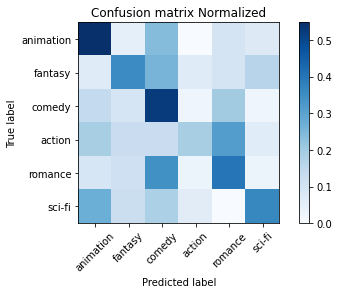

In [10]:
logreg = linear_model.LogisticRegression(n_jobs=-1, C=1e5)
logreg.fit(train_data_features, train_data['tag'])

predict(count_vectorizer, logreg, test_data)

テストデータを使って評価すると、44% とまあまあ良い正答率です。特に amination や comedy の成績が良いです。

LogisticRegression の coef_ 属性を使うと、どのベクトルの次元の影響力が強いのか観察出来ます。coef_ は tag の数 x 特徴ベクトルの次元(単語の数) で、数字が大きいほど影響力が大きいです。

In [11]:
for tag_index, tag in enumerate(logreg.classes_):
    print(f"{tag}: {logreg.coef_[tag_index]})")

action: [ 0.75573721 -0.47581172  0.54842262 ... -1.99314501 -0.2582481
 -0.09286177])
animation: [-0.50553718  1.19642655 -0.12130582 ... -0.68777642 -0.11919812
  0.69879877])
comedy: [-0.03884728  1.97907157  0.74785816 ...  5.12966293 -1.77318799
 -0.08446958])
fantasy: [-0.62133302 -0.01795021 -0.63881266 ... -0.42830753 -1.0628616
 -0.05787423])
romance: [-0.98587051 -2.00795811 -0.30017212 ... -0.37590957  1.07365758
 -0.35639341])
sci-fi: [ 1.39585078 -0.67377808 -0.23599017 ... -1.64452441  2.13983822
 -0.10719979])


coef_ をソートしてジャンルを特徴づける単語を確認します。割と納得の結果なのではと思います。

In [12]:
def most_influential_words(vectorizer, classifier, num_words=10):
    words = vectorizer.get_feature_names()
    for tag_index, tag in enumerate(classifier.classes_):
        coef = classifier.coef_[tag_index]
        sorted_coef = sorted(enumerate(coef), key=lambda x:x[1], reverse=True)
        sorted_word = [words[index] for index, value in sorted_coef]
        print(f"{tag}: {sorted_word[:num_words]})")    
        
most_influential_words(count_vectorizer, logreg, 5)

action: ['america', 'assassin', 'conspiracy', 'pursue', 'terrorists'])
animation: ['forest', 'fight', 'snow', 'ending', 'adventurous'])
comedy: ['mistaken', 'comedy', 'dealer', 'actress', 'comedian'])
fantasy: ['national', 'princess', 'dragon', 'kingdom', 'beast'])
romance: ['decide', 'relationships', 'troubled', 'beth', 'nazi'])
sci-fi: ['future', 'futuristic', 'cube', 'enterprise', 'space'])


## Character N-grams

次は N-grams です。N-grams というのは、単語で区切る事すらせずに、前後 n 個の文字列の頻度を数えて特徴量とする物です。乱暴なようですが、意外とそれなりの結果が出ます。ここでは 2 から 5 までの文字を区切って特徴量を作ります。

In [13]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
train_data_features = n_gram_vectorizer.fit_transform(train_data['plot'])
logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 2min 14s, sys: 31.5 s, total: 2min 45s
Wall time: 13.1 s


評価してみます。

accuracy 0.3950617283950617
confusion matrix
 [[17  3 10  1  9  2]
 [ 5  9  9  3  1  4]
 [15  8 41  4 16  2]
 [ 2  2  3  3  2  4]
 [ 5  1 14  1 13  1]
 [ 9  1  5  4  1 13]]
(row=expected, col=predicted)


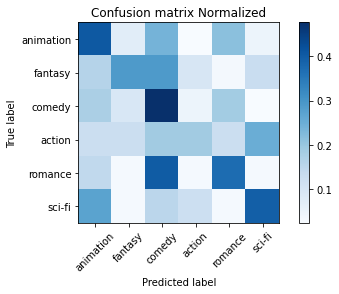

In [14]:
predict(n_gram_vectorizer, logreg, test_data)

約 40% とまあまあです。

In [15]:
most_influential_words(n_gram_vectorizer, logreg, 5)

action: ['my', ' war', 'ank', 'es ', 'ist '])
animation: [' an', 'oy', 'ot', 'y d', 'ima'])
comedy: ['ks', 'ud', 'per', 'ate', 'man '])
fantasy: ['au', 'king', 'rag', 'd of ', 't d'])
romance: ['so', 'vel', ' love', 'par', 'ili'])
sci-fi: ['fu', 'rg', 'ar ', ' a f', ' fu'])


影響力の大きい特徴を見ても、よくこんなもので 40% も当てるなと思います。

## TF-IDF

次に、Bag of words をもう少し進化させた [term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) 略して TF-IDF を試します。TF-IDF は Bag of words で単語の出現頻度を数えた後、文の特徴となるような珍しい単語の重みを上げ、平凡な単語の重みを下げます。

In [16]:
%%time
tf_vect = TfidfVectorizer(
    #tokenizer=nltk.word_tokenize,
    #ngram_range=(1, 2),
)
train_data_features = tf_vect.fit_transform(train_data['plot'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 27.2 s, sys: 7.18 s, total: 34.4 s
Wall time: 2.61 s


accuracy 0.4609053497942387
confusion matrix
 [[21  3 11  0  3  4]
 [ 2 10 10  2  2  5]
 [ 6  3 51  2 22  2]
 [ 4  4  2  3  1  2]
 [ 4  1 16  1 13  0]
 [ 7  3  6  3  0 14]]
(row=expected, col=predicted)


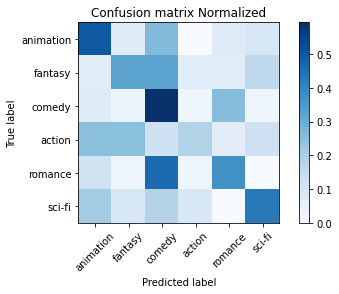

In [17]:
predict(tf_vect, logreg, test_data)

正答率 46% です。Bag of words が 44% だったのでちょっと向上しました。tokenizer を変えたり N-gram を指定して複数単語で特徴量を見たりすると多少向上します。

In [18]:
most_influential_words(tf_vect, logreg, 5)

action: ['army', 'assassin', 'terrorists', 'terrorist', 'drug'])
animation: ['animated', 'forest', 'animals', 'named', 'halloween'])
comedy: ['comedy', 'up', 'jewish', 'around', 'jail'])
fantasy: ['king', 'louie', 'magical', 'harry', 'magic'])
romance: ['love', 'apartment', 'troubled', 'she', 'dance'])
sci-fi: ['future', 'alien', 'space', 'human', 'planet'])


影響の大きい特徴もちょっと良いような気がします。

## Word2Vec

いよいよ Word2Vec を試します。Word2Vec というのは、大量の文章を学習して単語の類似度などの関係を反映させた特徴ベクトルを上手に抽出します。Bag of words や TF-IDF が「文章」に対応する特徴ベクトルを抽出するのに対して、Word2Vec では「単語」に対応する特徴ベクトルを抽出します。

参考:
* [Word2Vec Model Tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html)
* [models.word2vec – Word2vec embeddings](https://radimrehurek.com/gensim/models/word2vec.html)
* [models.keyedvectors – Store and query word vectors](https://radimrehurek.com/gensim/models/keyedvectors.html)

学習には時間がかかるので、予め Google News dataset から作成された model を使います。

In [19]:
%%time
wv = api.load('word2vec-google-news-300')

CPU times: user 38.3 s, sys: 2.06 s, total: 40.4 s
Wall time: 41.4 s


単語の特徴ベクトルは配列アクセスの文法を使って取得出来ます。

In [20]:
wv["Tokyo"]

array([-0.109375  ,  0.27148438, -0.00787354,  0.14648438, -0.20117188,
        0.06396484, -0.22851562, -0.07421875,  0.02185059,  0.22167969,
       -0.40820312,  0.55859375,  0.46289062, -0.34960938, -0.21582031,
       -0.20117188, -0.10058594,  0.140625  ,  0.234375  , -0.06201172,
        0.05615234, -0.31835938, -0.05834961,  0.03662109,  0.01171875,
       -0.02416992, -0.078125  ,  0.01513672, -0.18652344,  0.08789062,
        0.19042969, -0.09033203, -0.421875  , -0.265625  , -0.19628906,
       -0.07080078, -0.09375   ,  0.15917969,  0.13574219, -0.06103516,
       -0.00558472, -0.06396484,  0.02185059,  0.296875  , -0.12402344,
        0.46875   , -0.02392578,  0.06689453,  0.05834961,  0.0559082 ,
        0.16699219, -0.00126648,  0.41796875, -0.05664062, -0.45898438,
        0.41015625, -0.18847656, -0.26953125,  0.11132812, -0.41992188,
       -0.09033203,  0.08935547,  0.04882812, -0.04394531,  0.20996094,
       -0.21582031,  0.00473022,  0.15136719,  0.2109375 ,  0.00

うまく学習すると、まるで単語の特徴ベクトルに演算が成り立つかのようになります。例えば以下は「日本にとっての東京はフランスにとって何だ?」というクイズを表します。

In [21]:
wv.similar_by_vector(wv["Tokyo"] - wv["Japan"] + wv["France"], 1)

[('Paris', 0.8110150694847107)]

次に「父が男なら母は何だ?」です。

In [22]:
wv.similar_by_vector(wv["man"] - wv["father"] + wv["mother"], 1)

[('woman', 0.8460322618484497)]

映画のレビューは単語ではなく文章なので、このままでは予測に使えません。そこで、文章の特徴ベクトルを得るためどうするかというと、単純に平均化すると良いそうです。

* 参考: [Mike Tamir, Classifying Text without (many) Labels](https://www.youtube.com/watch?v=7gTjYwiaJiU)

まず単語を切り出します。その際に、nltk.corpus.stopwords を使って一般的すぎる単語を除外します。

In [24]:
nltk.download('stopwords')

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            if word.lower() in stopwords.words('english'):
                continue
            tokens.append(word)
    return tokens

tng_plot = "The series begins with the crew of the Enterprise-D put on trial by an omnipotent being known as Q, who became a recurring character. The god-like entity threatens the extinction of humanity for being a race of savages, forcing them to solve a mystery at nearby Farpoint Station to prove their worthiness to be spared. After successfully solving the mystery and avoiding disaster, the crew departs on its mission to explore strange new worlds.The series begins with the crew of the Enterprise-D put on trial by an omnipotent being known as Q, who became a recurring character. The god-like entity threatens the extinction of humanity for being a race of savages, forcing them to solve a mystery at nearby Farpoint Station to prove their worthiness to be spared. After successfully solving the mystery and avoiding disaster, the crew departs on its mission to explore strange new worlds."
print(w2v_tokenize_text(tng_plot))

['series', 'begins', 'crew', 'Enterprise-D', 'put', 'trial', 'omnipotent', 'known', 'became', 'recurring', 'character', 'god-like', 'entity', 'threatens', 'extinction', 'humanity', 'race', 'savages', 'forcing', 'solve', 'mystery', 'nearby', 'Farpoint', 'Station', 'prove', 'worthiness', 'spared', 'successfully', 'solving', 'mystery', 'avoiding', 'disaster', 'crew', 'departs', 'mission', 'explore', 'strange', 'new', 'worlds.The', 'series', 'begins', 'crew', 'Enterprise-D', 'put', 'trial', 'omnipotent', 'known', 'became', 'recurring', 'character', 'god-like', 'entity', 'threatens', 'extinction', 'humanity', 'race', 'savages', 'forcing', 'solve', 'mystery', 'nearby', 'Farpoint', 'Station', 'prove', 'worthiness', 'spared', 'successfully', 'solving', 'mystery', 'avoiding', 'disaster', 'crew', 'departs', 'mission', 'explore', 'strange', 'new', 'worlds']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tyamamiya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


次に、単語ごとの word2vec の特徴ベクトルを get_vector で求めて平均化します。`wv[単語]` ではなく `wv.get_vector(単語, norm=True)` を使うのは、正規化したベクトルを使うからです。平均したあとまた最後に gensim.matutils.unitvec で正規化しておきます。

In [25]:
def averaging(wv, words):
    mean = np.mean([wv.get_vector(word, norm=True)
                        for word
                        in words
                        if word in wv], axis=0)
    return unitvec(mean)

def averaging_text(wv, text):
    return averaging(wv, w2v_tokenize_text(text))

確認のため、得られた文章の特徴ベクトルがどんな単語に近いか見てみます。ピンと来ますでしょうか?

In [26]:
wv.similar_by_vector(averaging_text(wv, tng_plot), restrict_vocab=100000, topn=20)

[('mystery', 0.4961079955101013),
 ('mysterious', 0.4670897126197815),
 ('fictional', 0.4605964720249176),
 ('supernatural', 0.448750764131546),
 ('confront', 0.4461035430431366),
 ('sort', 0.44454988837242126),
 ('solve', 0.4442543089389801),
 ('character', 0.44423702359199524),
 ('mysteries', 0.4432906210422516),
 ('solving', 0.43936479091644287),
 ('confronts', 0.43834561109542847),
 ('villain', 0.43776965141296387),
 ('humanity', 0.4373060464859009),
 ('mythical', 0.43303632736206055),
 ('peculiar', 0.432568222284317),
 ('revolves_around', 0.42918798327445984),
 ('alien', 0.42697280645370483),
 ('confronting', 0.4260649085044861),
 ('vanishes', 0.4246973693370819),
 ('villains', 0.4238564074039459)]

それでも一応この方法で教師データとテストデータから特徴ベクトルを作ります。

In [27]:
%%time

def averaging_list(wv, text_list):
    return [averaging_text(wv, text) for text in text_list]

X_train_word_average = averaging_list(wv, train_data["plot"])
X_test_word_average = averaging_list(wv, test_data["plot"])

CPU times: user 18.4 s, sys: 4.83 s, total: 23.2 s
Wall time: 23.1 s


accuracy 0.5349794238683128
confusion matrix
 [[24  1 11  1  1  4]
 [ 2 11  6  6  4  2]
 [ 6  6 57  3 12  2]
 [ 2  3  1  6  1  3]
 [ 4  1 13  0 14  3]
 [ 7  2  3  2  1 18]]
(row=expected, col=predicted)
CPU times: user 9.97 s, sys: 1.48 s, total: 11.4 s
Wall time: 1.48 s


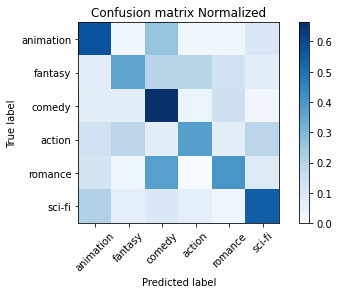

In [28]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, max_iter=2000)
logreg.fit(X_train_word_average, train_data['tag'])

predicted = logreg.predict(X_test_word_average)
evaluate_prediction(predicted, test_data.tag)

53% 出ました。今までで一番高いですが、正直なんで上手くいくのか謎です。テスト用の粗筋と特徴ベクトル近辺の単語を見てみます。

In [29]:
def examine_word2vec(text):
    print(text)
    vector = averaging_text(wv, text)
    pprint(wv.similar_by_vector(vector, restrict_vocab=100000, topn=20))

examine_word2vec(test_data.iloc[56]['plot'])

Scruffy but irresistibly attractive Yau Muk-yan, without a job or a place to live, moves in with sensitive, shy piano tuner Chan Kar-fu. Both are disturbed, then obsessed, by the amateurish piano playing of upstairs neighbour Mok Man-yee. Obsession turns to romance, and romance to fantasy. The film is structured in four "movements": two themes (Yau Muk-yan, Mok Man-yee), a duet (Yau Muk-yan & Mok Man-yee), and a set of variations (a wild fantasy of Chan Kar-fu in his new novel).
[('dreamy', 0.5190651416778564),
 ('Chan', 0.5157312750816345),
 ('Cheung', 0.5124940872192383),
 ('romance', 0.5102624893188477),
 ('romantic', 0.4882933795452118),
 ('Wong', 0.47440242767333984),
 ('sexy', 0.4723252058029175),
 ('neurotic', 0.47144070267677307),
 ('Leung', 0.468058705329895),
 ('moody', 0.46737581491470337),
 ('weird', 0.4657338857650757),
 ('Cheng', 0.4650360941886902),
 ('Yuen', 0.45778849720954895),
 ('vamp', 0.45643094182014465),
 ('Chow', 0.45602890849113464),
 ('Yu', 0.4541877210140228)